# PID codes

0 - not b tagged

1 - b tagged

13 - muon

14 - neutrino

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Helper Functions

In [2]:
def decode_line(line, varying_mass):
    """ Decode line in text file to momentum and other kinematic information of interest """
    
    if varying_mass:
        step = 7
    else:
        step = 6
    
    # Kinematic info to extract stored in lists
    pTs = []
    etas = []
    phis = []
    ms = []
    PIDs = []

    lepton = []
    neutrino = []
    
    if varying_mass:
        topmass=float(line.split()[6])
    else:
        topmass = -1
    
    for k in range(int(len(line.split())/step)):
        pT = float(line.split()[k*step+1])
        eta = float(line.split()[k*step+2])
        phi = float(line.split()[k*step+3])
        m = float(line.split()[k*step+4])
        PID = int(line.split()[k*step+5])

        pTs+=[pT]
        etas+=[eta]
        phis+=[phi]
        ms+=[m]
        if (k==1):
            PIDs+=[14]
            neutrino = [pT,eta,phi,m]
        elif (PID==13):
            PIDs+=[PID]
            lepton = [pT,eta,phi,m]
        else:
            PIDs+=[PID]
        pass
    
    return pTs, etas, phis, ms, PIDs, neutrino, lepton, topmass

In [3]:
def p4_from_ptetaphim(jet):
    """ Convert from (pT, eta, phi, mass) to (px, py, pz, pE) """
    pT, eta, phi, m = jet
    
    px = pT*np.cos( phi)
    py = pT*np.sin( phi)
    pz = pT*np.sinh(eta)
    pE = (m**2 + (pT*np.cosh(eta))**2)**0.5
    
    return [px, py, pz, pE]

def jet_mass(jet_list):
    """ Calculate the jet mass given a list of 4-vectors
    Arg:
        - jet_list (list): List of 4-vectors with format (pT, eta, phi, mass) 
    Returns:
        - jet mass (scalar)
    """
    # Convert from (pT, eta, phi, mass) to (px, py, pz, pE)
    p4_jets = [p4_from_ptetaphim(jet) for jet in jet_list]
    # Sum each component
    px, py, pz, pE = [sum(p_i) for p_i in zip(*p4_jets)]
    # Calculate jet mass
    mass = (pE**2-px**2-py**2-pz**2)**0.5
    return mass

In [4]:
def select_jets(pTs, etas, phis, ms, PIDs, lepton):
    """ Selects the leptonic and hadronic b-jets and the two hadronic jets from the W decay 
    Args:
        - pTs (list): List of pT for each jet in the event
        - etas (list): List of eta for each jet in the event
        - phis (list): List of phi for each jet in the event
        - ms (list): List of the mass for each jet in the event
        - PIDs (list): List of PID for each jet in the event
        - lepton (list): lepton 4-vector (pT, eta, phi, m)
        
    Returns:
        4-vectors for [leptonbjet, hadronicbjet, wjet1, wjet2] with format (pT, eta, phi, m)
    
    """
    
    leptonbjet = []
    wjet1 = []
    wjet2 = []
    hadronicbjet = []
    
    #First, find the b-jet closest to the lepton.
    dRmin = 999.
    whichbjet = -1
    for k in range(len(pTs)):
        if (PIDs[k] != 1):
            continue
        #print(lepton[1],etas[k])
        dR = ((lepton[1]-etas[k])**2+(lepton[2]-phis[k])**2)**0.5
        if (dR < dRmin):
            dRmin = dR
            whichbjet = k
            pass
        pass

    #Now, let's take the other leading b jet as the second b jet.
    pTmax = -1
    whichbjet2 = -1
    for k in range(len(pTs)):
        if (PIDs[k] != 1):
            continue
        if (whichbjet==k):
            continue
        if (pTs[k] > pTmax):
            pTmax = pTs[k]
            whichbjet2 = k
            pass
        pass

    #Now, let's take the remaining jets and find the pair closest to the W mass.
    w1 = -1
    w2 = -1
    dmW = 999.
    for k in range(len(pTs)):
        if (PIDs[k] != 0): # only look at non-b-tagged jets
            continue
        for k2 in range(k+1, len(pTs)):
            if (PIDs[k2] != 0): # only look at non-b-tagged jets
                continue
                
            mJJ = jet_mass([[pTs[k], etas[k], phis[k], ms[k]], [pTs[k2], etas[k2], phis[k2], ms[k2]]])
            if (abs(mJJ - 80.4) < dmW):
                dmW = abs(mJJ - 80.4)
                w1 = k
                w2 = k2
                pass
            pass
        pass

    if (whichbjet < 0 or whichbjet2 < 0 or w1 < -1 or w2 < -1 or dRmin < 0.4 or dmW>10):
#         print("Raising error in select_jets(...)")
        raise ValueError("Error in select jets (whichbjet = {}) < 0 or (whichbjet2 = {}) < 0 or (w1 = {}) < -1 or (w2 = {}) < -1 or (dRmin = {}) < 0.4".format(whichbjet, whichbjet2, w1, w2, dRmin))
    else:
        leptonbjet = [pTs[whichbjet],etas[whichbjet],phis[whichbjet],ms[whichbjet]]
        hadronicbjet = [pTs[whichbjet2],etas[whichbjet2],phis[whichbjet2],ms[whichbjet2]]
        wjet1 = [pTs[w1],etas[w1],phis[w1],ms[w1]]
        wjet2 = [pTs[w2],etas[w2],phis[w2],ms[w2]]
        return leptonbjet, hadronicbjet, wjet1, wjet2


In [5]:
def solve_for_neutrino_pz(lepton, neutrino):
    """ Solve for neutrino p_z and correct the eta value. 
    It's identically set to zero in .txt file (because it's estimated from missing pT?)
    This calculates the right value and updates the neutrino eta value. 
    """
    #solve for neutrino pz
    #mW^2 = 2(pl*pv - pzl*pzv - pTl*pTv)
    #     = 2(pl*sqrt(pTv^2 + pzv^2) - pzl*pzv - pxl*pxv - pyl*pyv)
    pl = lepton[0]*np.cosh(lepton[1])
    plz = lepton[0]*np.sinh(lepton[1])
    plx = lepton[0]*np.cos(lepton[2])
    ply = lepton[0]*np.sin(lepton[2])
    pvx = neutrino[0]*np.cos(neutrino[2])
    pvy = neutrino[0]*np.sin(neutrino[2])
    a = (plz**2-pl**2)
    b = (80.4**2+2.*(plx*pvx + ply*pvy))*plz
    c = (80.4**2/2. + plx*pvx + ply*pvy)**2 - pl**2*neutrino[0]**2
    pz = 0.
    if (b**2-4*a*c > 0):
        pz = (-b + (b**2-4*a*c)**0.5)/(2.*a)
        if (abs((-b - (b**2-4*a*c)**0.5)/(2.*a)) < pz):
            pz = (-b - (b**2-4*a*c)**0.5)/(2.*a)
            pass
        pass
    eta = np.arcsinh(pz/neutrino[0])
    neutrino[1] = eta
#     pv = neutrino[0]*np.cosh(neutrino[1])
#     pvz = neutrino[0]*np.sinh(neutrino[1])
#     print("check",np.sqrt(2.*(pl*pv - plz*pvz - plx*pvx - ply*pvy)))

In [6]:
def read_file(filename, varying_mass, cutoff = None):
    succeed = 0
    failed = 0
    events = []
    selection_mask = [] # keep track of which events we are selecting to match particle level to detector level data
    with open(filename) as f:
        mycounter = 0
        for line in f:
            event = {}
            mycounter+=1
            if (mycounter > (cutoff if cutoff is not None else 1e20)):
                break
            if (mycounter%10000==0):
                print("   ", mycounter)
                print("succeed = ", succeed, ". failed = ", failed, flush = True)

            # Decode line
            pTs, etas, phis, ms, PIDs, neutrino, lepton, topmass = decode_line(line, varying_mass = varying_mass)
            
            event['pTs'] = pTs
            event['etas'] = etas
            event['phis'] = phis
            event['ms'] = ms
            event['PIDs'] = PIDs
            
            # Get subjets
            try:
                leptonbjet, hadronicbjet, wjet1, wjet2 = select_jets(pTs, etas, phis, ms, PIDs, lepton)
                succeed +=1
                selection_mask.append(True)
            except:
                
                # Catch error from selection of jets
#                 print(err)
                failed+=1
                selection_mask.append(False)
                events.append(event)
                continue
            # Correct neutrino momentum
            solve_for_neutrino_pz(lepton, neutrino)

            # Calculate W-mass
            mW = jet_mass([wjet1, wjet2]) 

            # Hadronic top mass
            mt_had = jet_mass([hadronicbjet, wjet1, wjet2])* 80.4/mW # NOTE: Applying w-mass calibration

            # Leptonic top mass
            mt_lep = jet_mass([leptonbjet, lepton, neutrino])
            
            # (Swapped) Hadronic top mass
            mt_had_swap = jet_mass([leptonbjet, wjet1, wjet2]) * 80.4/mW
            
            # (Swapped) Leptonic top mass
            mt_lep_swap = jet_mass([hadronicbjet, lepton, neutrino])
            
            # Leptonic W mass 
            #mW_lep = jet_mass([lepton, neutrino])
     
            event['neutrino'] = neutrino + [0.1]           # (pT, eta, phi, m)
            event['lepton'] = lepton + [0.2]               # (pT, eta, phi, m)
            
            event['leptonbjet'] = leptonbjet + [0.3]       # (pT, eta, phi, m)
            event['hadronicbjet'] = hadronicbjet + [0.4]   # (pT, eta, phi, m)
            event['wjet1'] = wjet1 + [0.5]                 # (pT, eta, phi, m)
            event['wjet2'] = wjet2 + [0.5]                 # (pT, eta, phi, m)
            
            event['mW'] = mW
            event['mt_had'] = mt_had
            event['mt_lep'] = mt_lep
            event['mt_had_swap'] = mt_had_swap
            event['mt_lep_swap'] = mt_lep_swap
            event['mt_MC'] = topmass
            
            events.append(event)
            #break
                        
    return events, selection_mask

# Varying Mass Data

In [ ]:
part_events, part_mask = read_file("/data1/users/bpnachman/DCTRFitting/output_part_varmass.txt", varying_mass=True, cutoff=None)
det_events,  det_mask  = read_file("/data1/users/bpnachman/DCTRFitting/output_det_varmass.txt",  varying_mass=True, cutoff=None)

    10000
succeed =  4102 . failed =  5897
    20000
succeed =  8141 . failed =  11858
    30000
succeed =  12193 . failed =  17806
    40000
succeed =  16333 . failed =  23666
    50000
succeed =  20451 . failed =  29548
    60000
succeed =  24558 . failed =  35441
    70000
succeed =  28677 . failed =  41322
    80000
succeed =  32765 . failed =  47234
    90000
succeed =  36802 . failed =  53197
    100000
succeed =  40904 . failed =  59095
    110000
succeed =  44996 . failed =  65003
    120000
succeed =  49129 . failed =  70870
    130000
succeed =  53218 . failed =  76781
    140000
succeed =  57278 . failed =  82721
    150000
succeed =  61333 . failed =  88666
    160000
succeed =  65418 . failed =  94581
    170000
succeed =  69519 . failed =  100480
    180000
succeed =  73568 . failed =  106431
    190000
succeed =  77686 . failed =  112313
    200000
succeed =  81744 . failed =  118255
    210000
succeed =  85892 . failed =  124107
    220000
succeed =  89919 . failed =  1

    1720000
succeed =  700738 . failed =  1019261
    1730000
succeed =  704818 . failed =  1025181
    1740000
succeed =  708964 . failed =  1031035
    1750000
succeed =  713115 . failed =  1036884
    1760000
succeed =  717201 . failed =  1042798
    1770000
succeed =  721274 . failed =  1048725
    1780000
succeed =  725400 . failed =  1054599
    1790000
succeed =  729398 . failed =  1060601
    1800000
succeed =  733500 . failed =  1066499
    1810000
succeed =  737590 . failed =  1072409
    1820000
succeed =  741641 . failed =  1078358
    1830000
succeed =  745711 . failed =  1084288
    1840000
succeed =  749743 . failed =  1090256
    1850000
succeed =  753785 . failed =  1096214
    1860000
succeed =  757913 . failed =  1102086
    1870000
succeed =  762040 . failed =  1107959
    1880000
succeed =  766075 . failed =  1113924
    1890000
succeed =  770072 . failed =  1119927
    1900000
succeed =  774112 . failed =  1125887
    1910000
succeed =  778239 . failed =  1131760


    3350000
succeed =  1365144 . failed =  1984855
    3360000
succeed =  1369186 . failed =  1990813
    3370000
succeed =  1373212 . failed =  1996787
    3380000
succeed =  1377347 . failed =  2002652
    3390000
succeed =  1381410 . failed =  2008589
    3400000
succeed =  1385451 . failed =  2014548
    3410000
succeed =  1389508 . failed =  2020491
    3420000
succeed =  1393564 . failed =  2026435
    3430000
succeed =  1397664 . failed =  2032335
    3440000
succeed =  1401726 . failed =  2038273
    3450000
succeed =  1405854 . failed =  2044145
    3460000
succeed =  1409890 . failed =  2050109
    3470000
succeed =  1413921 . failed =  2056078
    3480000
succeed =  1417999 . failed =  2062000
    3490000
succeed =  1422052 . failed =  2067947
    3500000
succeed =  1426174 . failed =  2073825
    3510000
succeed =  1430273 . failed =  2079726
    3520000
succeed =  1434355 . failed =  2085644
    3530000
succeed =  1438447 . failed =  2091552
    3540000
succeed =  1442488 

    4970000
succeed =  2025695 . failed =  2944304
    4980000
succeed =  2029717 . failed =  2950282
    4990000
succeed =  2033778 . failed =  2956221
    5000000
succeed =  2037849 . failed =  2962150
    10000
succeed =  874 . failed =  9125
    20000
succeed =  1730 . failed =  18269
    30000
succeed =  2612 . failed =  27387
    40000
succeed =  3461 . failed =  36538
    50000
succeed =  4393 . failed =  45606
    60000
succeed =  5264 . failed =  54735
    70000
succeed =  6113 . failed =  63886
    80000
succeed =  6943 . failed =  73056
    90000
succeed =  7803 . failed =  82196
    100000
succeed =  8670 . failed =  91329
    110000
succeed =  9526 . failed =  100473
    120000
succeed =  10429 . failed =  109570
    130000
succeed =  11243 . failed =  118756
    140000
succeed =  12101 . failed =  127898
    150000
succeed =  12972 . failed =  137027
    160000
succeed =  13844 . failed =  146155
    170000
succeed =  14760 . failed =  155239
    180000
succeed =  15596 .

    1680000
succeed =  146705 . failed =  1533294
    1690000
succeed =  147594 . failed =  1542405
    1700000
succeed =  148494 . failed =  1551505
    1710000
succeed =  149366 . failed =  1560633
    1720000
succeed =  150241 . failed =  1569758
    1730000
succeed =  151108 . failed =  1578891
    1740000
succeed =  151983 . failed =  1588016
    1750000
succeed =  152890 . failed =  1597109
    1760000
succeed =  153754 . failed =  1606245
    1770000
succeed =  154590 . failed =  1615409
    1780000
succeed =  155505 . failed =  1624494
    1790000
succeed =  156378 . failed =  1633621
    1800000
succeed =  157301 . failed =  1642698
    1810000
succeed =  158201 . failed =  1651798
    1820000
succeed =  159099 . failed =  1660900
    1830000
succeed =  159970 . failed =  1670029
    1840000
succeed =  160849 . failed =  1679150
    1850000
succeed =  161698 . failed =  1688301
    1860000
succeed =  162609 . failed =  1697390
    1870000
succeed =  163465 . failed =  1706534


    3320000
succeed =  289416 . failed =  3030583
    3330000
succeed =  290267 . failed =  3039732
    3340000
succeed =  291123 . failed =  3048876
    3350000
succeed =  291961 . failed =  3058038
    3360000
succeed =  292854 . failed =  3067145
    3370000
succeed =  293709 . failed =  3076290
    3380000
succeed =  294567 . failed =  3085432
    3390000
succeed =  295444 . failed =  3094555
    3400000
succeed =  296308 . failed =  3103691
    3410000
succeed =  297192 . failed =  3112807
    3420000
succeed =  298049 . failed =  3121950
    3430000
succeed =  298944 . failed =  3131055
    3440000
succeed =  299797 . failed =  3140202
    3450000
succeed =  300665 . failed =  3149334
    3460000
succeed =  301525 . failed =  3158474
    3470000
succeed =  302433 . failed =  3167566
    3480000
succeed =  303313 . failed =  3176686
    3490000
succeed =  304226 . failed =  3185773
    3500000
succeed =  305115 . failed =  3194884
    3510000
succeed =  306021 . failed =  3203978


In [ ]:
np.savez('varmass.npz', part_events = part_events, 
                        det_events  = det_events,
                        part_mask   = part_mask,
                        det_mask    = det_mask
        )

# Fixed Mass

In [7]:
part_events, part_mask = read_file(
    "/data1/users/bpnachman/DCTRFitting/output_part_172_5.txt",
    varying_mass=False,
    cutoff=None)
det_events, det_mask = read_file(
    "/data1/users/bpnachman/DCTRFitting/output_det_172_5.txt",
    varying_mass=False,
    cutoff=None)

# part_events, part_mask = read_file("/data1/users/bpnachman/DCTRFitting/output_part_175_0.txt", varying_mass=False, cutoff=None)
# det_events,  det_mask  = read_file("/data1/users/bpnachman/DCTRFitting/output_det_175_0.txt",  varying_mass=False, cutoff=None)

    10000
succeed =  4072 . failed =  5927
    20000
succeed =  8030 . failed =  11969
    30000
succeed =  12012 . failed =  17987
    40000
succeed =  16005 . failed =  23994
    50000
succeed =  20023 . failed =  29976
    60000
succeed =  24029 . failed =  35970
    70000
succeed =  28035 . failed =  41964
    80000
succeed =  32061 . failed =  47938
    90000
succeed =  36160 . failed =  53839
    100000
succeed =  40177 . failed =  59822
    110000
succeed =  44134 . failed =  65865
    120000
succeed =  48094 . failed =  71905
    130000
succeed =  52079 . failed =  77920
    140000
succeed =  56120 . failed =  83879
    150000
succeed =  60163 . failed =  89836
    160000
succeed =  64153 . failed =  95846
    170000
succeed =  68214 . failed =  101785
    180000
succeed =  72227 . failed =  107772
    190000
succeed =  76282 . failed =  113717
    200000
succeed =  80275 . failed =  119724
    210000
succeed =  84234 . failed =  125765
    220000
succeed =  88258 . failed =  1

    750000
succeed =  64558 . failed =  685441
    760000
succeed =  65407 . failed =  694592
    770000
succeed =  66299 . failed =  703700
    780000
succeed =  67154 . failed =  712845
    790000
succeed =  68032 . failed =  721967
    800000
succeed =  68870 . failed =  731129
    810000
succeed =  69681 . failed =  740318
    820000
succeed =  70591 . failed =  749408
    830000
succeed =  71390 . failed =  758609
    840000
succeed =  72244 . failed =  767755
    850000
succeed =  73089 . failed =  776910
    860000
succeed =  73897 . failed =  786102
    870000
succeed =  74769 . failed =  795230
    880000
succeed =  75644 . failed =  804355
    890000
succeed =  76558 . failed =  813441
    900000
succeed =  77436 . failed =  822563
    910000
succeed =  78283 . failed =  831716
    920000
succeed =  79123 . failed =  840876
    930000
succeed =  80008 . failed =  849991
    940000
succeed =  80868 . failed =  859131
    950000
succeed =  81720 . failed =  868279
    960000
su

In [8]:
np.savez('top_172_5.npz', part_events = part_events, 
                        det_events  = det_events,
                        part_mask   = part_mask,
                        det_mask    = det_mask
        )

# np.savez('top_175_0.npz', part_events = part_events, 
#                         det_events  = det_events,
#                         part_mask   = part_mask,
#                         det_mask    = det_mask
#         )

# Process npz files

In [ ]:
# data = np.load('top_172_5.npz', allow_pickle = True)
# data = np.load('top_175_0.npz', allow_pickle = True)
data = np.load('varmass.npz', allow_pickle = True)

In [ ]:
part_events = data['part_events']
det_events  = data['det_events']
part_mask   = data['part_mask']
det_mask    = data['det_mask']

## All jets in event

In [11]:
# particle_alljets = []
# detector_alljets = []

# for part_event, det_event, dmask, pmask in zip(part_events, det_events, det_mask, part_mask):
#     # Only select events that passed the cuts at both particle and detector level
#     if (dmask ==  True) and (pmask == True):
#         if part_event['mt_MC'] == -1:
#             mtop = np.random.uniform(170, 180)
#         else:
#             mtop = part_event['mt_MC']
            
#         particle_alljets.append(np.stack((part_event['pTs'],
#                                        part_event['etas'],
#                                        part_event['phis'],
#                                        part_event['ms'],
#                                        part_event['PIDs'],
#                                        mtop*np.ones_like(part_event['PIDs'])
#                                      )).T)
#         detector_alljets.append(np.stack((det_event['pTs'],
#                                        det_event['etas'],
#                                        det_event['phis'],
#                                        det_event['ms'],
#                                        det_event['PIDs'],
#                                        mtop*np.ones_like(det_event['PIDs'])
#                                      )).T)
#         break

## top-subjets

In [ ]:
particle_6j = []
detector_6j = []
part_masses = []
det_masses = []

for part_event, det_event, dmask, pmask in zip(part_events, det_events,
                                               det_mask, part_mask):
    # Only select events that passed the cuts at both particle and detector level
    if (dmask == True) and (pmask == True):
        if part_event['mt_MC'] == -1:
            mtop = np.random.uniform(170, 180)
        else:
            mtop = part_event['mt_MC']

        particle_6j.append(
            np.stack((
                part_event['leptonbjet'] + [mtop],
                part_event['hadronicbjet'] + [mtop],
                part_event['lepton'] + [mtop],
                part_event['neutrino'] + [mtop],
                part_event['wjet1'] + [mtop],
                part_event['wjet2'] + [mtop],
            )))
        part_masses.append([
            part_event['mt_lep'], part_event['mt_had'],
            part_event['mt_lep_swap'], part_event['mt_had_swap'],
            part_event['mW']
        ])

        detector_6j.append(
            np.stack((
                det_event['leptonbjet'] + [mtop],
                det_event['hadronicbjet'] + [mtop],
                det_event['lepton'] + [mtop],
                det_event['neutrino'] + [mtop],
                det_event['wjet1'] + [mtop],
                det_event['wjet2'] + [mtop],
            )))
        det_masses.append([
            det_event['mt_lep'], det_event['mt_had'], det_event['mt_lep_swap'],
            det_event['mt_had_swap'], det_event['mW']
        ])

particle_6j = np.array(particle_6j)
detector_6j = np.array(detector_6j)
part_masses = np.array(part_masses)
det_masses = np.array(det_masses)

In [ ]:
print(particle_6j.shape)
print(detector_6j.shape)
print(part_masses.shape)
print(det_masses.shape)

In [ ]:
# np.save('part_172_5_6j.npy', particle_6j)
# np.save('det_172_5_6j.npy', detector_6j)
# np.save('part_172_5_6j_obs.npy', part_masses)
# np.save('det_172_5_6j_obs.npy', det_masses)

# np.save('part_175_0_6j.npy', particle_6j)
# np.save('det_175_0_6j.npy', detector_6j)
# np.save('part_175_0_6j_obs.npy', part_masses)
# np.save('det_175_0_6j_obs.npy', det_masses)


np.save('part_varmass_6j.npy', particle_6j)
np.save('det_varmass_6j.npy', detector_6j)
np.save('part_varmass_6j_obs.npy', part_masses)
np.save('det_varmass_6j_obs.npy', det_masses)




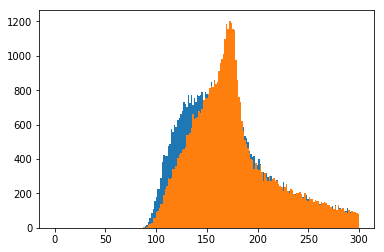

In [116]:
# plt.hist(det_masses[:,1], bins = np.linspace(0,300,200))
# plt.hist(part_masses[:,1], bins = np.linspace(0,300,200))
# plt.show()

In [4]:
sum(det_mask)/len(det_mask)

0.076791